# Setup

In [3]:
import llmlex
import openai
import sympy as sp
import pickle

import numpy as np
import matplotlib.pyplot as plt
import torch.nn

from kan import *
import os


In [4]:
client = openai.OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=os.getenv("OPENROUTER_API_KEY") if os.getenv("OPENROUTER_API_KEY") else "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", 
)
llmlex.llm.check_key_limit(client)

120.30797195

# First Function $e^{\sin{\pi x} + y^2}$

## Fit KAN

cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-03 | test_loss: 1.58e-03 | reg: 1.42e+01 | : 100%|█| 100/100 [00:13<00:00,  7.21


saving model version 0.1


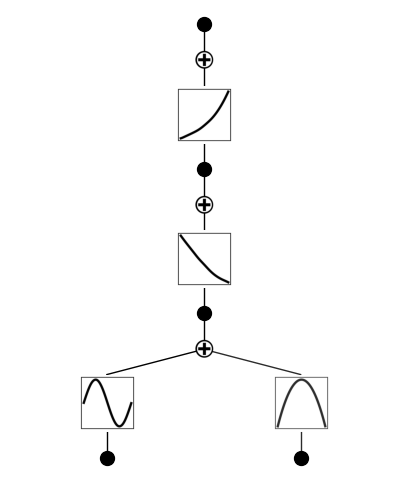

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# initialize KAN with G=3
model = KAN(width=[2,1,1,1], grid=7, k=3, seed=0, device=device, symbolic_enabled=False)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, train_num=10000, test_num=1000, device=device)
res = model.fit(dataset, opt="LBFGS", steps=100);
model.plot()

In [7]:
pruned_model = model.prune(node_th=0.2, edge_th=0.2)

saving model version 0.2


## Fit Splines

2025-04-02 17:05:01,549 - llmlex.llmLEx - INFO - Processing KAN model connections
2025-04-02 17:05:01,550 - llmlex.llmLEx - INFO - Processing non-symbolic activation function (0,0,0)


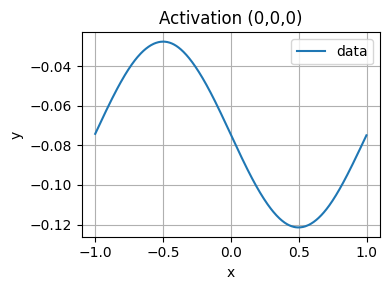

2025-04-02 17:05:01,625 - llmlex.llmLEx - INFO - Running genetic algorithm for connection (0,0,0)
2025-04-02 17:05:01,999 - llmlex.llmLEx - INFO - Constant function is not a good fit: Score: -0.99626225233078, for constant: [-0.07408782]
2025-04-02 17:05:02,000 - llmlex.llmLEx - INFO - Generating initial population asynchronously
2025-04-02 17:05:06,738 - llmlex.llmLEx - INFO - Generated 10 individuals
2025-04-02 17:05:06,739 - llmlex.llmLEx - INFO - Initial population best: score=-8.951318477556924e-07, params=[ 0.04691995  3.14150789  3.14154378 -0.07456407], ansatz: params[0] * np.sin(params[1] * x + params[2]) + params[3]...
2025-04-02 17:05:06,740 - llmlex.llmLEx - INFO - Exit condition met after initial population
2025-04-02 17:05:06,740 - llmlex.llmLEx - INFO - Successfully found expression for connection (0,0,0)



API Call Statistics:
  Successful calls (end-to-end): 10
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 10 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 10 succeeded, 0 failed (100.00% success)
  Function Conversion: 10 succeeded, 0 failed (100.00% success)
  Curve Fitting: 10 succeeded, 0 failed (100.00% success)

Error types:
  No errors
Approximation for (0,0,0): params[0] * np.sin(params[1] * x + params[2]) + params[3], with score -8.951318477556924e-07 and parameters [ 0.047  3.142  3.142 -0.075]


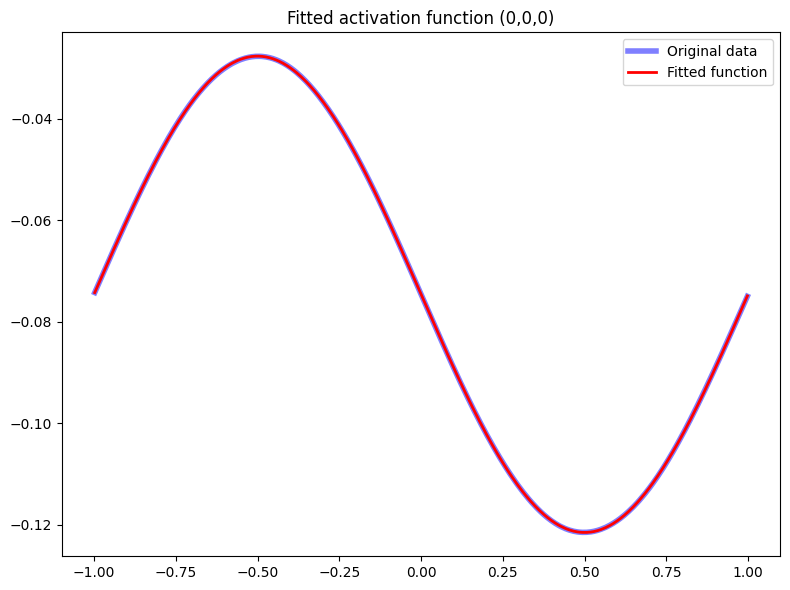

2025-04-02 17:05:06,840 - llmlex.llmLEx - INFO - Processing non-symbolic activation function (0,1,0)


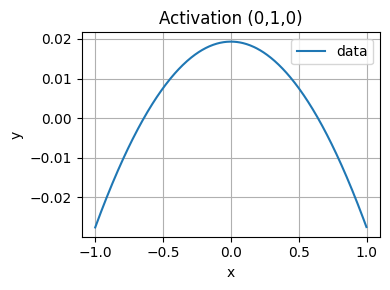

2025-04-02 17:05:06,908 - llmlex.llmLEx - INFO - Running genetic algorithm for connection (0,1,0)
2025-04-02 17:05:06,909 - llmlex.llmLEx - INFO - Constant function is not a good fit: Score: -1.8315480947494507, for constant: [0.00328124]
2025-04-02 17:05:06,910 - llmlex.llmLEx - INFO - Generating initial population asynchronously
2025-04-02 17:05:30,704 - llmlex.llmLEx - INFO - Generated 10 individuals
2025-04-02 17:05:30,706 - llmlex.llmLEx - INFO - Initial population best: score=-1.6460343488233775e-07, params=[-0.04692208  0.01932464], ansatz: params[0] * x**2 + params[1]...
2025-04-02 17:05:30,706 - llmlex.llmLEx - INFO - Exit condition met after initial population
2025-04-02 17:05:30,707 - llmlex.llmLEx - INFO - Successfully found expression for connection (0,1,0)



API Call Statistics:
  Successful calls (end-to-end): 10
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 10 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 10 succeeded, 0 failed (100.00% success)
  Function Conversion: 10 succeeded, 0 failed (100.00% success)
  Curve Fitting: 10 succeeded, 0 failed (100.00% success)

Error types:
  No errors
Approximation for (0,1,0): params[0] * x**2 + params[1], with score -1.6460343488233775e-07 and parameters [-0.047  0.019]


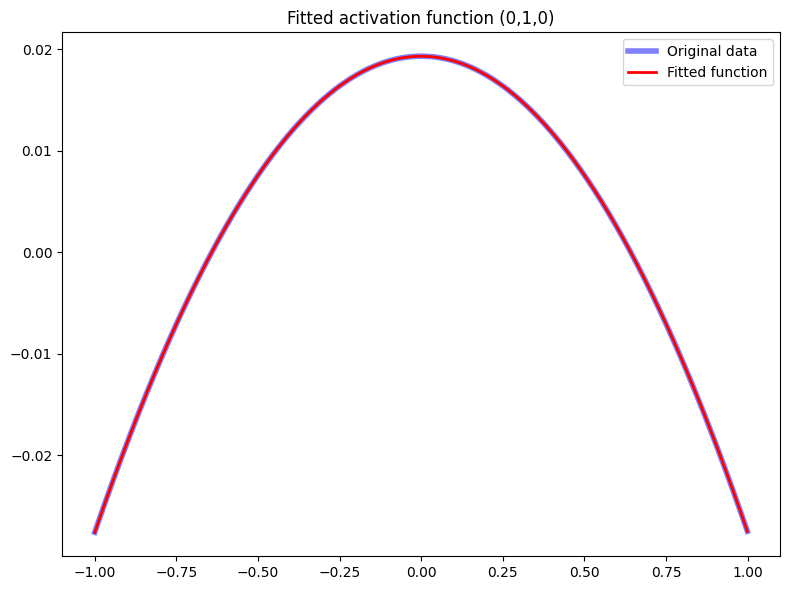

2025-04-02 17:05:30,812 - llmlex.llmLEx - INFO - Processing non-symbolic activation function (1,0,0)


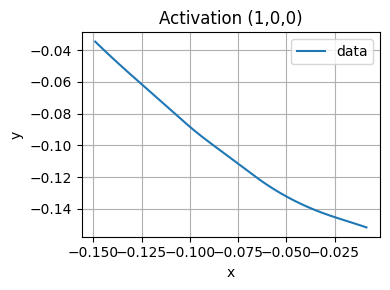

2025-04-02 17:05:30,881 - llmlex.llmLEx - INFO - Running genetic algorithm for connection (1,0,0)
2025-04-02 17:05:30,882 - llmlex.llmLEx - INFO - Constant function is not a good fit: Score: -1.456903100013733, for constant: [-0.1110468]
2025-04-02 17:05:30,883 - llmlex.llmLEx - INFO - Generating initial population asynchronously
2025-04-02 17:05:35,782 - llmlex.llmLEx - INFO - Generated 10 individuals
2025-04-02 17:05:35,783 - llmlex.llmLEx - INFO - Initial population best: score=-0.001266751904040575, params=[-0.15576285 -0.32432888  3.45090697], ansatz: params[0] + params[1] * x + params[2] * x**2...
2025-04-02 17:05:35,783 - llmlex.llmLEx - INFO - Exit condition met after initial population
2025-04-02 17:05:35,784 - llmlex.llmLEx - INFO - Successfully found expression for connection (1,0,0)



API Call Statistics:
  Successful calls (end-to-end): 10
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 10 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 10 succeeded, 0 failed (100.00% success)
  Function Conversion: 10 succeeded, 0 failed (100.00% success)
  Curve Fitting: 10 succeeded, 0 failed (100.00% success)

Error types:
  No errors
Approximation for (1,0,0): params[0] + params[1] * x + params[2] * x**2, with score -0.001266751904040575 and parameters [-0.156 -0.324  3.451]


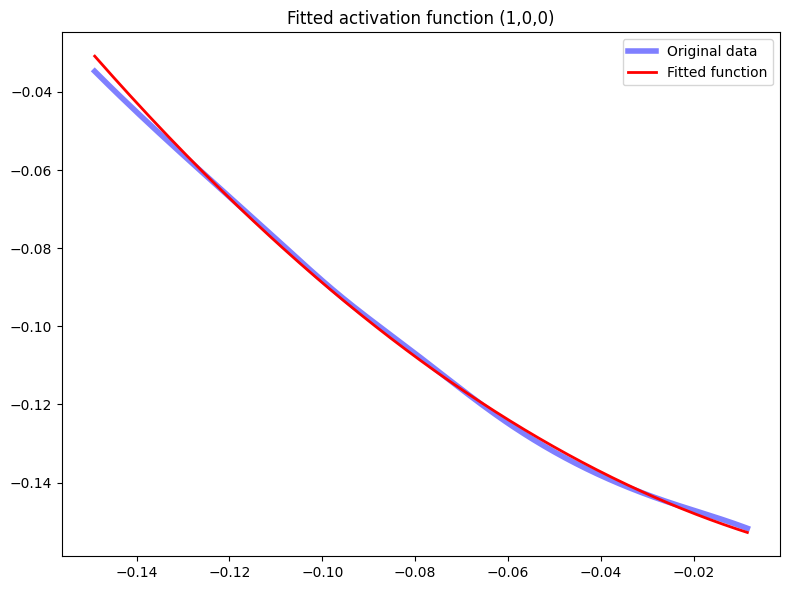

2025-04-02 17:05:35,890 - llmlex.llmLEx - INFO - Processing non-symbolic activation function (2,0,0)


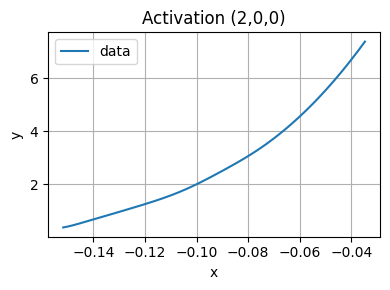

2025-04-02 17:05:35,962 - llmlex.llmLEx - INFO - Running genetic algorithm for connection (2,0,0)
2025-04-02 17:05:35,964 - llmlex.llmLEx - INFO - Constant function is not a good fit: Score: -3.059933662414551, for constant: [1.84716472]
2025-04-02 17:05:35,964 - llmlex.llmLEx - INFO - Generating initial population asynchronously
2025-04-02 17:06:00,602 - llmlex.llmLEx - INFO - Generated 10 individuals
2025-04-02 17:06:00,603 - llmlex.llmLEx - INFO - Initial population best: score=-0.0008921845001168549, params=[14.26589792 16.33069472 -0.78507348], ansatz: params[0] * np.exp(params[1] * x) + params[2]...
2025-04-02 17:06:00,604 - llmlex.llmLEx - INFO - Exit condition met after initial population
2025-04-02 17:06:00,605 - llmlex.llmLEx - INFO - Successfully found expression for connection (2,0,0)



API Call Statistics:
  Successful calls (end-to-end): 10
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 10 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 10 succeeded, 0 failed (100.00% success)
  Function Conversion: 10 succeeded, 0 failed (100.00% success)
  Curve Fitting: 10 succeeded, 0 failed (100.00% success)

Error types:
  No errors
Approximation for (2,0,0): params[0] * np.exp(params[1] * x) + params[2], with score -0.0008921845001168549 and parameters [14.266 16.331 -0.785]


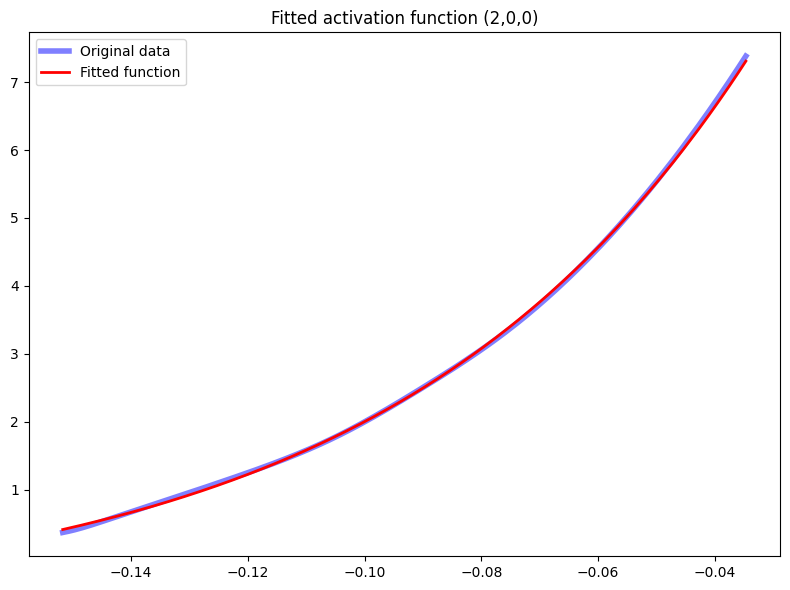

2025-04-02 17:06:00,708 - llmlex.llmLEx - INFO - KAN conversion complete: 4 total connections
2025-04-02 17:06:00,708 - llmlex.llmLEx - INFO - Connection breakdown: 0 symbolic, 0 zero, 4 processed
2025-04-02 17:06:00,806 - llmlex.llmLEx - INFO - API key usage whilst this kan_to_symbolic was running: $0.05


In [8]:
sym_expr = llmlex.kan_to_symbolic(model, client, gpt_model="openai/gpt-4o", exit_condition=min(res['train_loss']).item(), use_async=True, population=10, generations=3, temperature=0.1)#not 10 and 3

In [10]:
symb_expr_sorted = llmlex.kanlex.sort_symb_expr(sym_expr)
node_data = llmlex.kanlex.build_expression_tree(model, symb_expr_sorted, top_k=3)
# Convert training data to numpy arrays for optimization
x_data = dataset['train_input'].cpu().numpy()#.flatten()
y_data = dataset['train_label'].cpu().numpy()#.flatten()

full_expressions = node_data['full_expressions']
# Optimize and simplify the expression
best_expressions, best_chi_squareds, result_dicts = llmlex.kanlex.optimize_expression(
    client, full_expressions, 'gpt-4o', x_data, y_data, 
    custom_system_prompt=None, original_f = f, prune_small_terms=True, plot_all=False
)
result_dict = result_dicts[0]
print(best_expressions)

AttributeError: module 'llmlex' has no attribute 'kanlex'

In [9]:
with open('./sym_expr_4o_func1.pkl', 'wb') as hnd:
    pickle.dump(sym_expr, hnd)

## Reconstructing Function

In [17]:
with open('./sym_expr_4o_func1.pkl', 'rb') as hnd:
    sym_expr = pickle.load(hnd)

In [8]:
# def learned_f_handwritten(X, *params):
#     #first layer - two nodes
#     x_0_0, x_0_1 = X
#     #first splines, i = 0, j = {0,1}
#     px_0_0_0 = params[0] + params[1]*x_0_0 + params[2]*x_0_0**2 + params[3]*x_0_0**3 + params[4]*np.sin(params[5]*x_0_0)
#     px_0_0_1 = params[6] + params[7] * x_0_1 + params[8] * x_0_1**2
#     # second layer - just one node, i =
#     x_1_0 = px_0_0_0 + px_0_0_1
#     px_1_0_0 = params[9] + params[10] * x_1_0 + params[11] * x_1_0**2
#     # third layer - one node
#     x_2_0 = px_1_0_0
#     px_2_0_0 = params[12] * np.exp(params[13] * x_2_0) + params[14]
#     # fourth layer - one node
#     x_3_0 = px_2_0_0
#     return x_3_0


### Alternatively, use `generate_learned_f` to generate the function code directly, and then minimize that. 

In [157]:
initial_params = []
for kan_conn, sub_res in sym_expr.items():
    if sub_res is None:
        print(f"Could not fit a function for connection {kan_conn}")
        continue
    highest_score_element = max((item for sublist in sub_res for item in sublist), key=lambda item: item['score'])
    print(f"Approximation for {kan_conn}: {highest_score_element['ansatz'].strip()}")
    print(f"Parameters are {np.round(highest_score_element['params'], 3)}")
    initial_params += list(highest_score_element['params'])


from LLMSR.llmSR import generate_learned_f
learned_f_string, total_params, best_params = generate_learned_f(sym_expr)
print(total_params)
print(learned_f_string)
# Execute the generated function code to create the actual function
exec(learned_f_string)

# Test the function with some parameters
print("Testing the generated function:")
test_params = np.random.uniform(-1, 1, total_params)  # Adjust size based on actual parameter count
test_input = (dataset['test_input'][0,0].item(), dataset['test_input'][0,1].item())
try:
    test_output = learned_f(test_input, *test_params)
    print(f"Input: {test_input}, Output: {test_output}")
except Exception as e:
    print(f"Error testing function: {e}")


Approximation for (0, 0, 0): params[0] * np.sin(params[1] * x + params[2]) + params[3]
Parameters are [ 0.047  3.142  3.142 -0.075]
Approximation for (0, 1, 0): params[0] * x**2 + params[1] * x + params[2]
Parameters are [-0.047  0.     0.019]
Approximation for (1, 0, 0): params[0] + params[1] * x + params[2] * np.log(-x)
Parameters are [-0.248 -1.161 -0.019]
Approximation for (2, 0, 0): params[0] + params[1] * x + params[2] * np.exp(params[3] * x)
Parameters are [ 1.892 12.955 12.953 22.131]
14
def learned_f(X, *params):
    # Layer 0 activations
    x_0_0, x_0_1 = X
    px_0_0_0 = params[0] * np.sin(params[1] * x_0_0 + params[2]) + params[3]
    px_0_1_0 = params[4] * x_0_1**2 + params[5] * x_0_1 + params[6]
    x_1_0 = px_0_0_0 + px_0_1_0
    px_1_0_0 = params[7] + params[8] * x_1_0 + params[9] * np.log(-x_1_0)
    x_2_0 = px_1_0_0
    px_2_0_0 = params[10] + params[11] * x_2_0 + params[12] * np.exp(params[13] * x_2_0)
    x_3_0 = px_2_0_0
    return x_3_0
Testing the generated func

In [161]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_3d_function(x0_range, x1_range, z_values, test_data, title, cmap='viridis', ax=None):
    """Plot a 3D surface with test data points."""
    if ax is None:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
    
    # Create meshgrid for plotting
    X0, X1 = np.meshgrid(x0_range, x1_range)
    
    # Plot the function surface
    surf = ax.plot_surface(X0, X1, z_values, cmap=cmap, alpha=0.8, 
                          linewidth=0, antialiased=True)
    
    # Plot the actual test data points
    test_x0, test_x1, test_y = test_data
    ax.scatter(test_x0, test_x1, test_y, c='red', marker='o', s=10, label='True data')
    
    # Add labels and title
    ax.set_xlabel('X0')
    ax.set_ylabel('X1')
    ax.set_zlabel('Y')
    ax.set_title(title)
    
    # Add colorbar
    plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    return surf, ax

def calculate_mse(func, params, inputs, true_outputs):
    """Calculate mean squared error between function predictions and true values."""
    predictions = np.array([func((x0, x1), *params) for x0, x1 in zip(inputs[0], inputs[1])])
    mse = np.mean((predictions - true_outputs)**2)
    return mse, predictions


<string>:7: RuntimeWarning: invalid value encountered in log


Mean Squared Error with optimized parameters: 0.000000
Mean Squared Error with initial parameters: 0.005084
Improvement factor: 311016516394.08x
Mean Squared Error with symbolic expression: 0.000000
Symbolic expression: exp(1.0*x1**2 - 1.0*sin(3.1416*x0 + 3.1416))


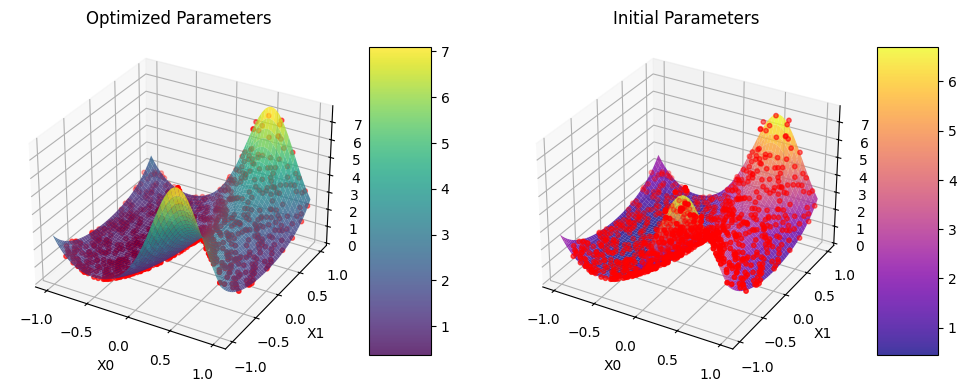

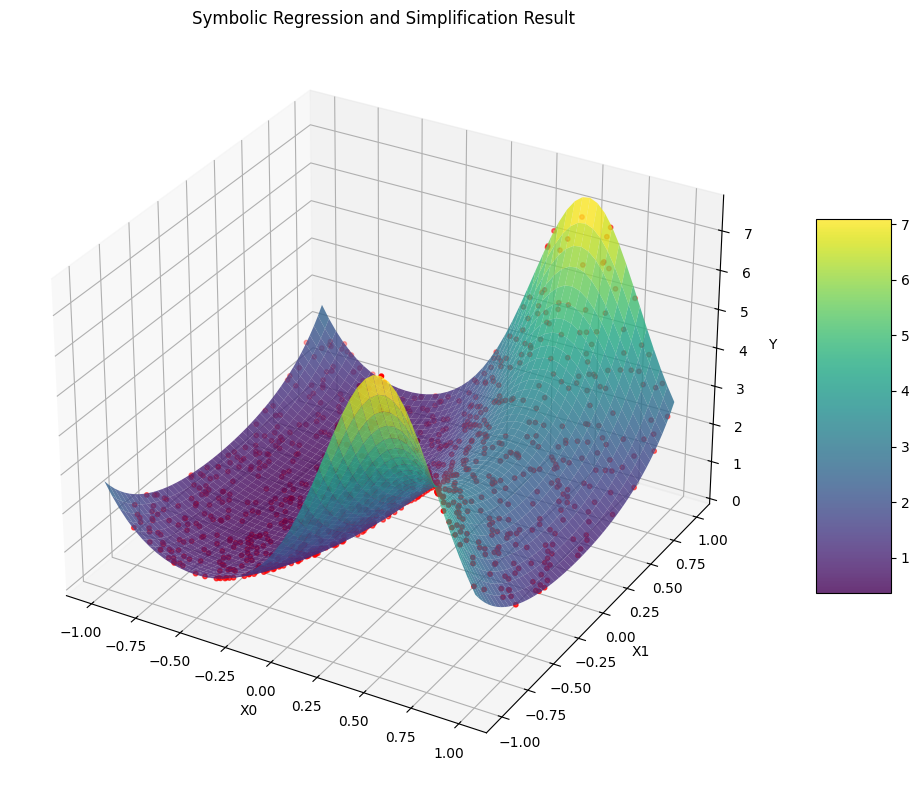

In [162]:

# Use initial parameters or best parameters from previous step
initial_params = best_params

# Optimize parameters using curve_fit
popt, _ = curve_fit(learned_f, 
                   (dataset['train_input'].cpu().detach().numpy()[:,0], 
                    dataset['train_input'].cpu().detach().numpy()[:,1]), 
                   dataset['train_label'].cpu().detach().numpy().flatten(), 
                   p0=initial_params, maxfev=100000)

# Create a grid of input points
x0_range = np.linspace(min(dataset['test_input'][:,0]), max(dataset['test_input'][:,0]), 50)
x1_range = np.linspace(min(dataset['test_input'][:,1]), max(dataset['test_input'][:,1]), 50)
X0, X1 = np.meshgrid(x0_range, x1_range)

# Extract test data
test_x0 = dataset['test_input'][:,0].cpu().detach().numpy()
test_x1 = dataset['test_input'][:,1].cpu().detach().numpy()
test_y = dataset['test_label'].cpu().detach().numpy().flatten()
test_data = (test_x0, test_x1, test_y)

# Compute function values for optimized parameters
Z_optimized = np.zeros(X0.shape)
for i in range(len(x0_range)):
    for j in range(len(x1_range)):
        Z_optimized[j, i] = learned_f((X0[j, i], X1[j, i]), *popt)

# Compute function values for initial parameters
Z_initial = np.zeros(X0.shape)
for i in range(len(x0_range)):
    for j in range(len(x1_range)):
        Z_initial[j, i] = learned_f((X0[j, i], X1[j, i]), *initial_params)

# Create figure with two subplots
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Plot optimized and initial parameter results
plot_3d_function(x0_range, x1_range, Z_optimized, test_data, 'Optimized Parameters', 'viridis', ax1)
plot_3d_function(x0_range, x1_range, Z_initial, test_data, 'Initial Parameters', 'plasma', ax2)

# Calculate and print MSE for both parameter sets
mse_optimized, _ = calculate_mse(learned_f, popt, (test_x0, test_x1), test_y)
mse_initial, _ = calculate_mse(learned_f, initial_params, (test_x0, test_x1), test_y)

print(f"Mean Squared Error with optimized parameters: {mse_optimized:.6f}")
print(f"Mean Squared Error with initial parameters: {mse_initial:.6f}")
print(f"Improvement factor: {mse_initial/mse_optimized:.2f}x")

# Plot symbolic regression result if available
if best_expressions[0] is not None:
    # Create a symbolic function from the best expression
    symbolic_func = eval('lambda x0,x1:' + best_expressions[0])
    
    # Compute function values with symbolic expression
    Z_symbolic = np.zeros(X0.shape)
    for i in range(len(x0_range)):
        for j in range(len(x1_range)):
            try:
                Z_symbolic[j, i] = symbolic_func(X0[j, i], X1[j, i])
            except:
                Z_symbolic[j, i] = np.nan
    
    # Create new figure for symbolic result
    fig2 = plt.figure(figsize=(12, 8))
    ax3 = fig2.add_subplot(111, projection='3d')
    
    # Plot symbolic regression result
    plot_3d_function(x0_range, x1_range, Z_symbolic, test_data, 
                    'Symbolic Regression and Simplification Result', 'viridis', ax3)
    
    # Calculate MSE for symbolic expression
    y_pred_symbolic = np.array([symbolic_func(x0, x1) for x0, x1 in zip(test_x0, test_x1)])
    mse_symbolic = np.mean((y_pred_symbolic - test_y)**2)
    
    print(f"Mean Squared Error with symbolic expression: {mse_symbolic:.6f}")
    print(f"Symbolic expression: {best_expressions[0]}")

plt.tight_layout()
plt.show()
